# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = [x for x in G10_FX if x != "USDCHF"]
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
raw_ppp = pd.read_csv("../../Dymon/Code Data/PPP_OECD.csv")
unmelt_ppp = raw_ppp.pivot_table(index=['Year'], columns='LOCATION')['Value']
lagged_ppp = unmelt_ppp.shift(3)
lagged_ppp.index = [datetime.strptime(str(x), "%Y") for x in lagged_ppp.index]
lagged_ppp.columns = ["USDAUD", "USDCAD", "USDCHF", "USDCNH", "USDEUR", "USDGBP", 
                      "USDHKD", "USDIDR", "USDINR", "USDJPY", "USDKRW", 
                      "USDNOK", "USDNZD", "USDSGD", "USDSEK"]
clean_ppp = lagged_ppp.pipe(fill_date, True)

# Data integrity

# Signal

In [5]:
sig = (spot_price_usd[universe] - clean_ppp[universe])/clean_ppp[universe]
sig = sig.pipe(omit_leading_na, "any").pipe(omit_trailing_na).pipe(high_minus_low, rank=True) * -1

In [6]:
# sig = (spot_price_usd[universe] - clean_ppp[universe])/clean_ppp[universe]
# scaler = abs(sig)
# scaler = scaler.div(scaler.sum(axis=1), axis=0)
# sig = scaler * sig.pipe(omit_leading_na, "any").pipe(omit_trailing_na).pipe(high_minus_low)
# sig = sig.pipe(cap_helper, 0.2)

# sig = ((spot_price_usd[universe] - clean_ppp[universe])/clean_ppp[universe])
# scaler = abs(sig.pipe(demean_xs))
# sig = scaler * sig.pipe(omit_leading_na, "any").pipe(omit_trailing_na).pipe(high_minus_low)

# Backtest Daily Rebal

In [7]:
daily_bt = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [8]:
get_summary(daily_bt)

Returns   : 0.08346104376178316
Vol       : 0.10167301576834055
SR        : 0.8208770353772833
Max DD    : -18.32

C Returns : 0.08142785600955606
C SR      : 0.7087941663741026
C Max DD  : -17.04

Hit rate  : 0.509
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.03


In [9]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK
annualized_return,2.237709,2.532024,-0.901644,1.023666,0.596915,2.380142,-0.085311,0.829581
sharpe,0.702854,0.626758,-0.228118,0.229743,0.103121,0.578222,-0.039465,0.128615
dollar_sharpe,0.646611,0.574589,-0.245679,0.221803,0.069204,0.54118,-0.047677,0.122774
trade_sharpe,0.677747,0.857221,-0.460166,0.103926,-0.106397,0.622494,-0.547145,0.031299
long_sharpe,0.243173,-1.141136,-9.165151,0.272344,0.188364,0.320688,-0.511324,0.031299
short_sharpe,0.924207,0.862667,-0.460431,-0.004721,-0.631681,0.677506,-1.860701,NaN
sortino,0.367802,0.285131,-0.113654,0.116651,0.067809,0.264725,-0.016577,0.089291
max_drawdown,-6.79973,-8.132898,-20.810214,-13.053103,-28.290215,-17.268617,-10.616,-36.007931
max_drawdown_start,2008-09-22,2004-11-25,2013-02-01,2009-11-16,2013-10-07,2008-03-13,2006-03-07,2002-04-08
max_drawdown_end,2013-04-11,2005-05-16,2016-12-20,2010-05-18,2015-06-05,2009-03-02,2008-04-22,2008-05-21


In [10]:
daily_bt.model_rtn.skew()

0.04170625311740825

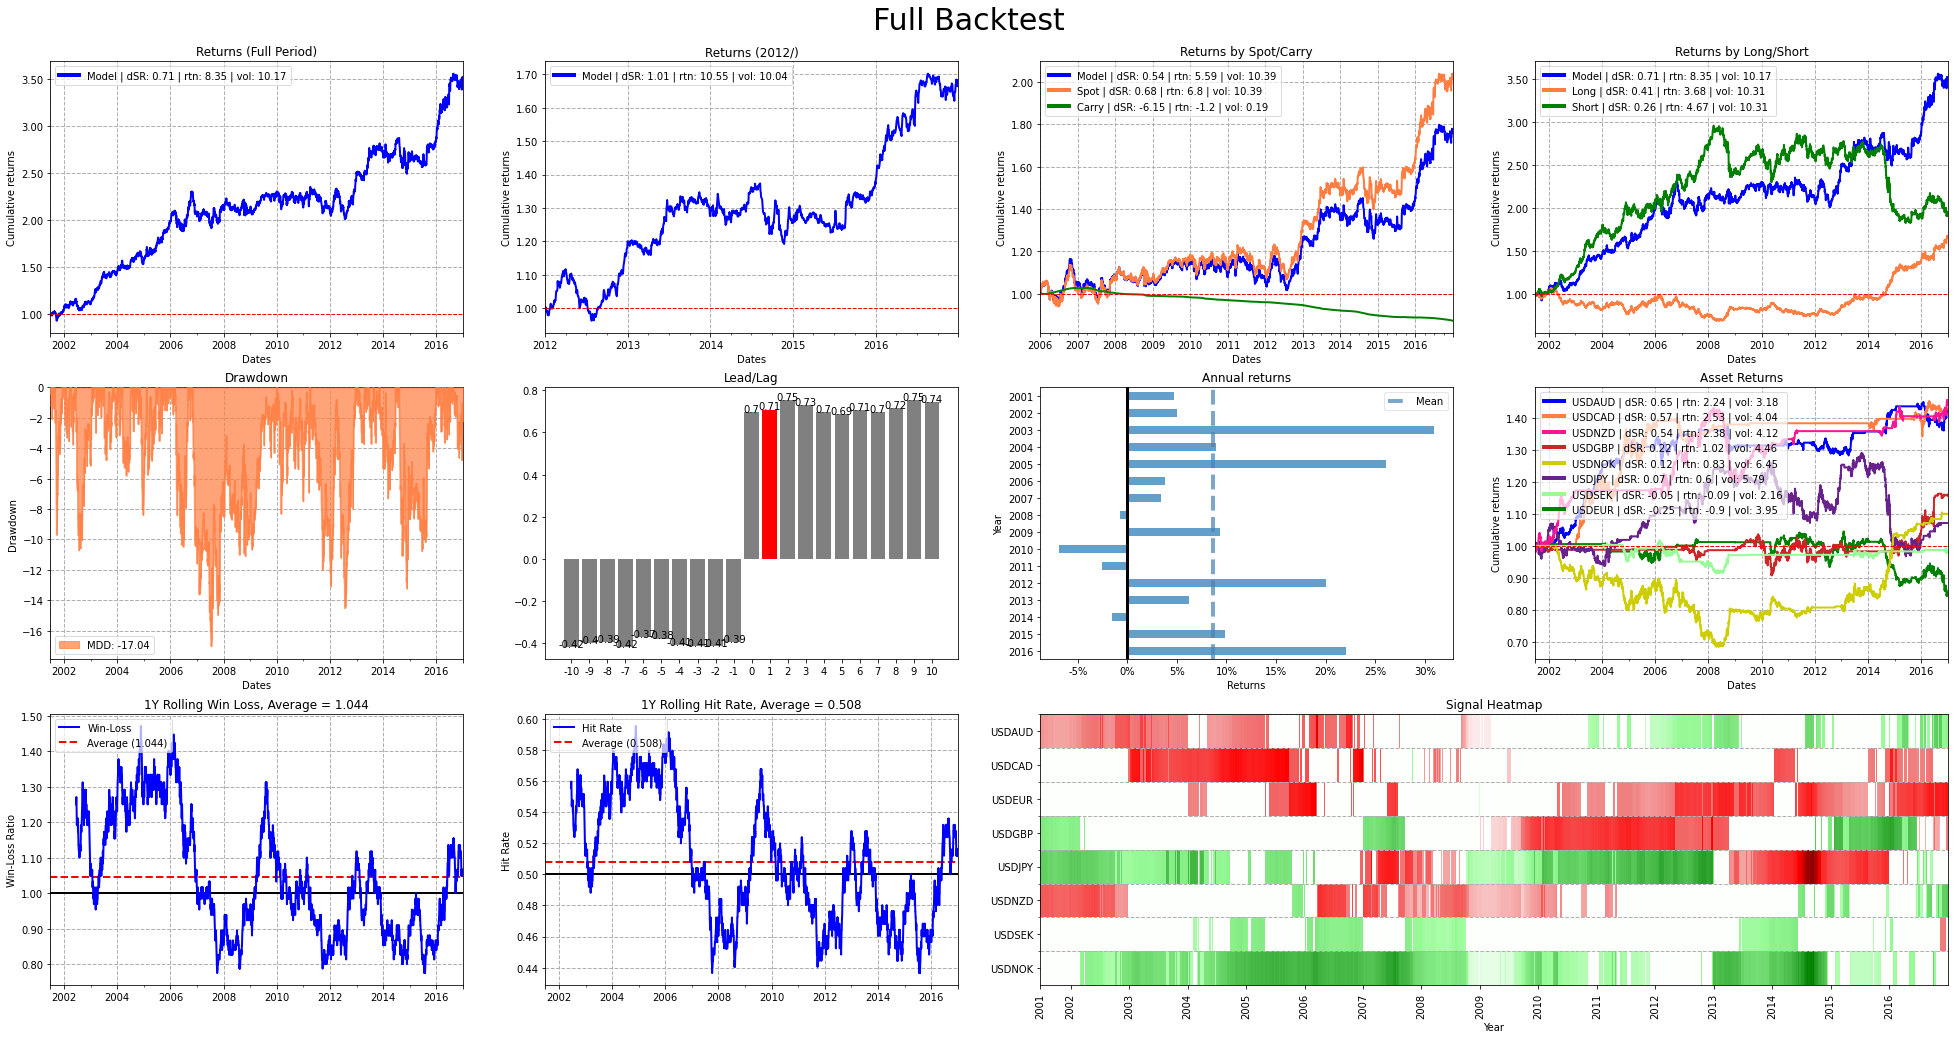

In [11]:
plot_bt(daily_bt)

<AxesSubplot:xlabel='Dates'>

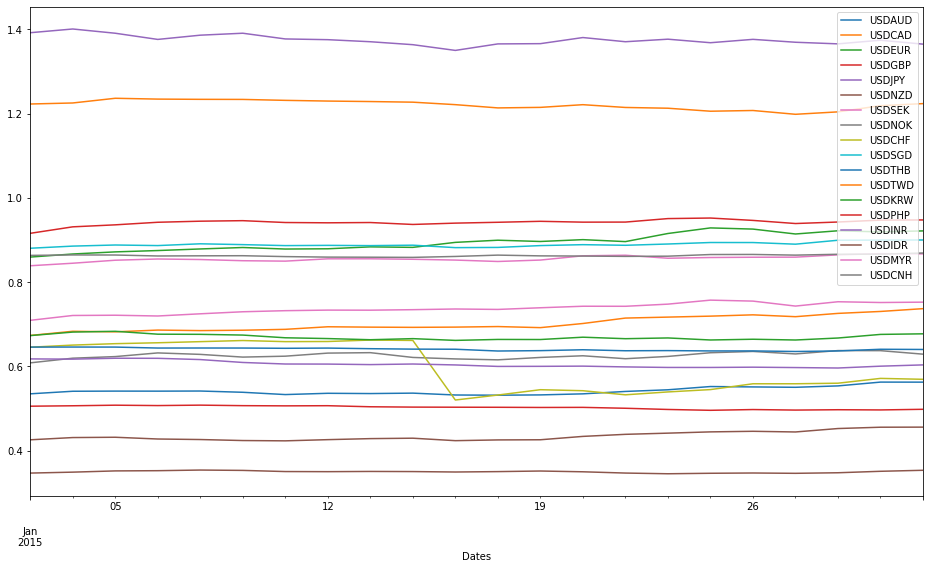

In [12]:
total_price_usd.loc["2015-01"].plot()

<AxesSubplot:xlabel='Dates'>

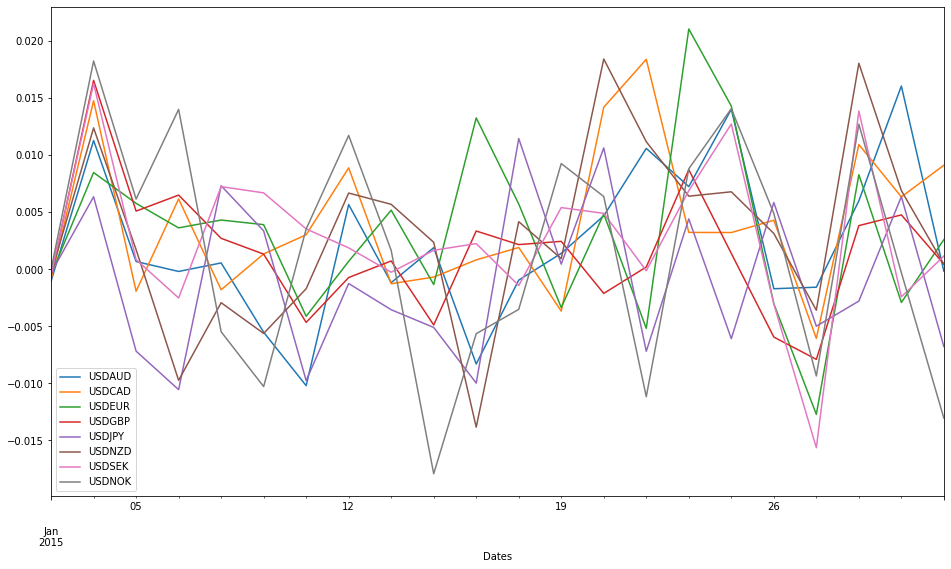

In [13]:
total_returns.loc["2015-01"].plot()

# Backtest Weekly Rebal

In [14]:
weekly_bt = Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":"friday"})
weekly_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [15]:
get_summary(weekly_bt)

Returns   : 0.08815336120265872
Vol       : 0.10194168944605429
SR        : 0.8647429886798952
Max DD    : -14.44

C Returns : 0.08648496983926776
C SR      : 0.7366264411331516
C Max DD  : -13.91

Hit rate  : 0.511
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.04


In [16]:
get_returns_stats(weekly_bt.asset_rtn, weekly_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK
annualized_return,2.404909,2.587538,-0.949866,0.86576,0.902184,2.707071,-0.0618,0.627714
sharpe,0.74977,0.631814,-0.244612,0.191559,0.154999,0.66113,-0.028054,0.097203
dollar_sharpe,0.701252,0.582988,-0.25321,0.180325,0.118095,0.60891,-0.036091,0.083153
trade_sharpe,0.885811,1.05554,-0.406299,0.22204,0.06855,0.926474,-0.107996,0.068211
long_sharpe,0.521014,NaN,NaN,0.498107,0.330376,0.937925,-0.123508,0.068211
short_sharpe,1.09004,1.05554,-0.406299,0.005409,-0.37972,0.926085,0.484209,NaN
sortino,0.381631,0.289507,-0.121084,0.09766,0.102494,0.306318,-0.01191,0.067276
max_drawdown,-8.278371,-8.267344,-22.855404,-12.712987,-28.125906,-17.684443,-10.088565,-36.27851
max_drawdown_start,2008-09-22,2004-11-25,2013-02-01,2009-11-16,2013-10-07,2008-03-13,2004-03-02,2001-07-03
max_drawdown_end,2013-04-11,2005-05-16,2016-12-20,2010-05-18,2015-06-05,2009-03-02,2008-04-22,2008-05-21


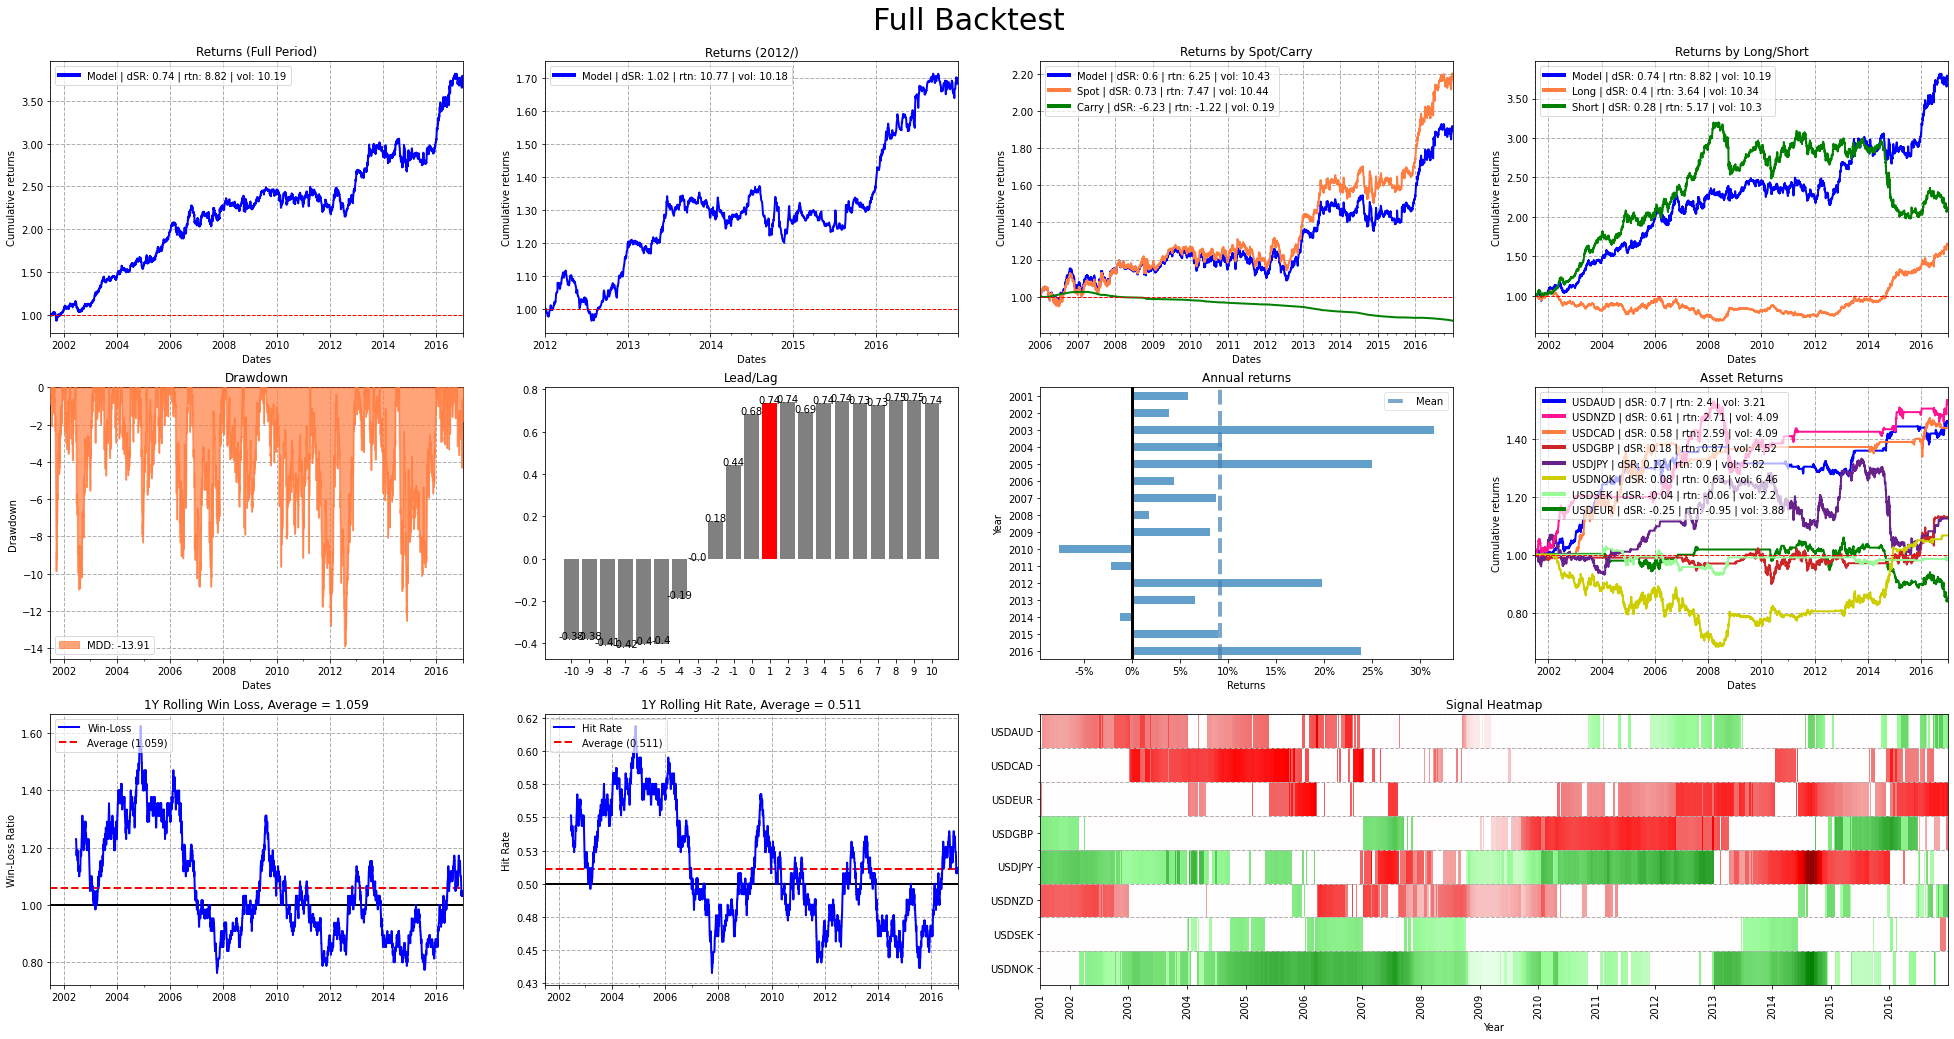

In [17]:
plot_bt(weekly_bt)

# Daily vs Weekly 

<AxesSubplot:title={'center':'Daily vs Weekly Rebal'}, xlabel='Dates', ylabel='Cumulative returns'>

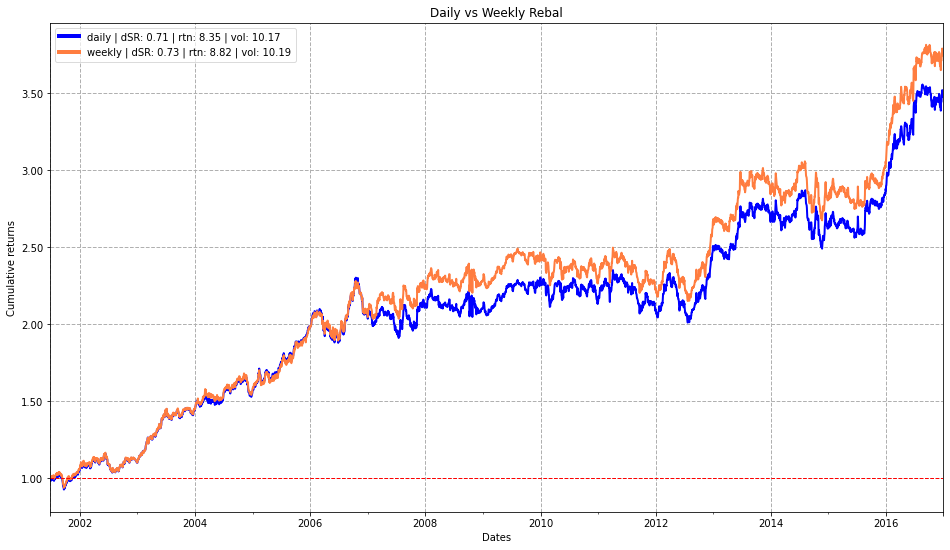

In [18]:
gen_plot_rtn(pd.concat([daily_bt.model_rtn.rename("daily"), weekly_bt.model_rtn.rename("weekly")], axis=1), main = "Daily vs Weekly Rebal")

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

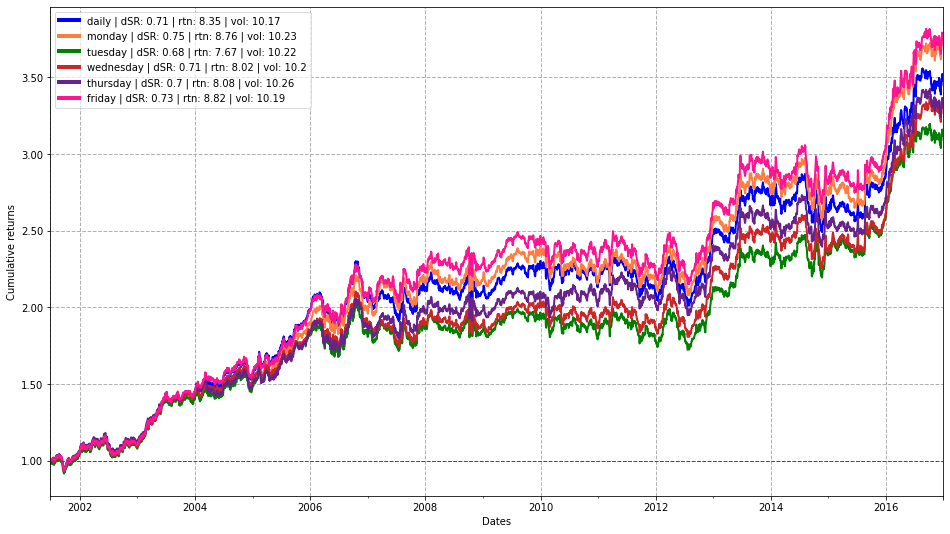

In [19]:
bts = [Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                 "thursday", "friday"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [20]:
# pickle.dump(daily_bt, open("../BT/value_sgreer_g10_daily.p", "wb"))
# daily_bt = pickle.load(open("../BT/value_sgreer_g10_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/value_sgreer_g10_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/value_sgreer_g10_weekly.p", "rb"))

# Regime Plot

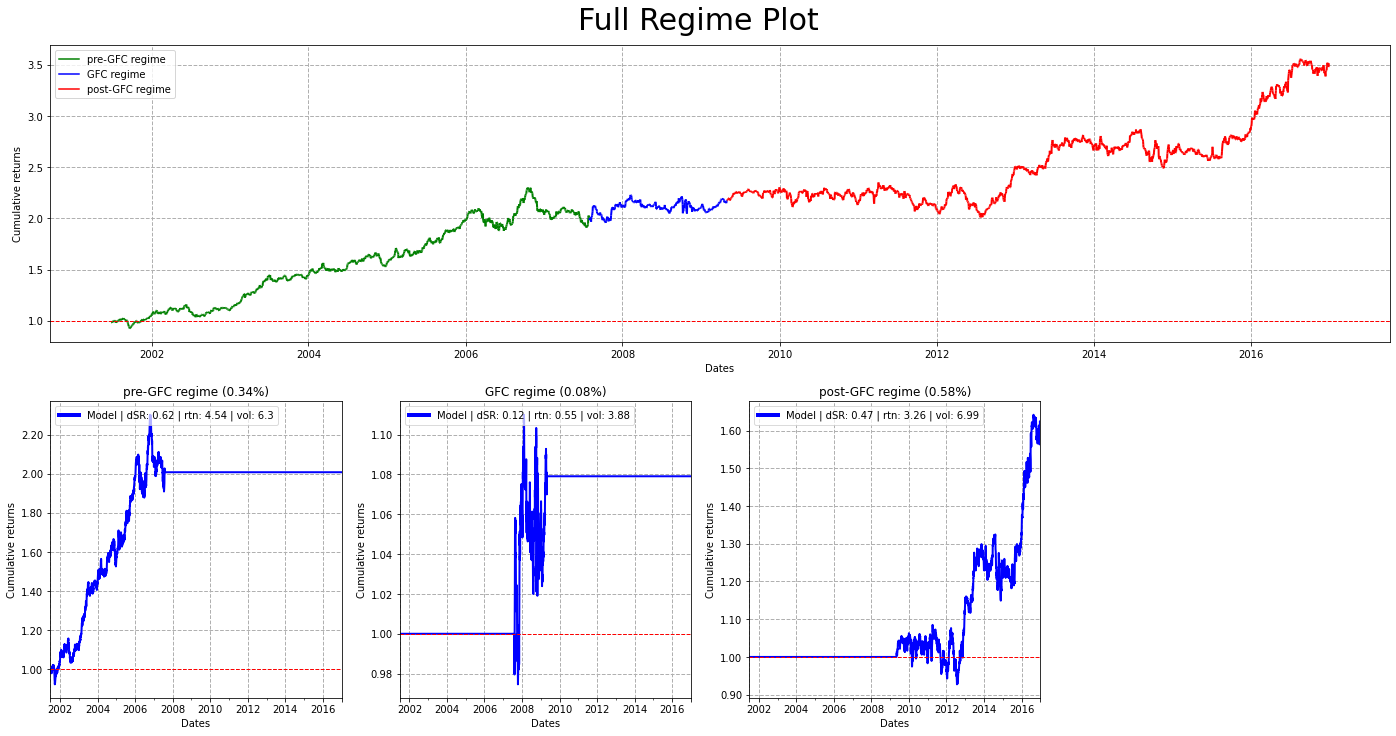

In [21]:
full_regime_plot(daily_bt, gfc_regime)

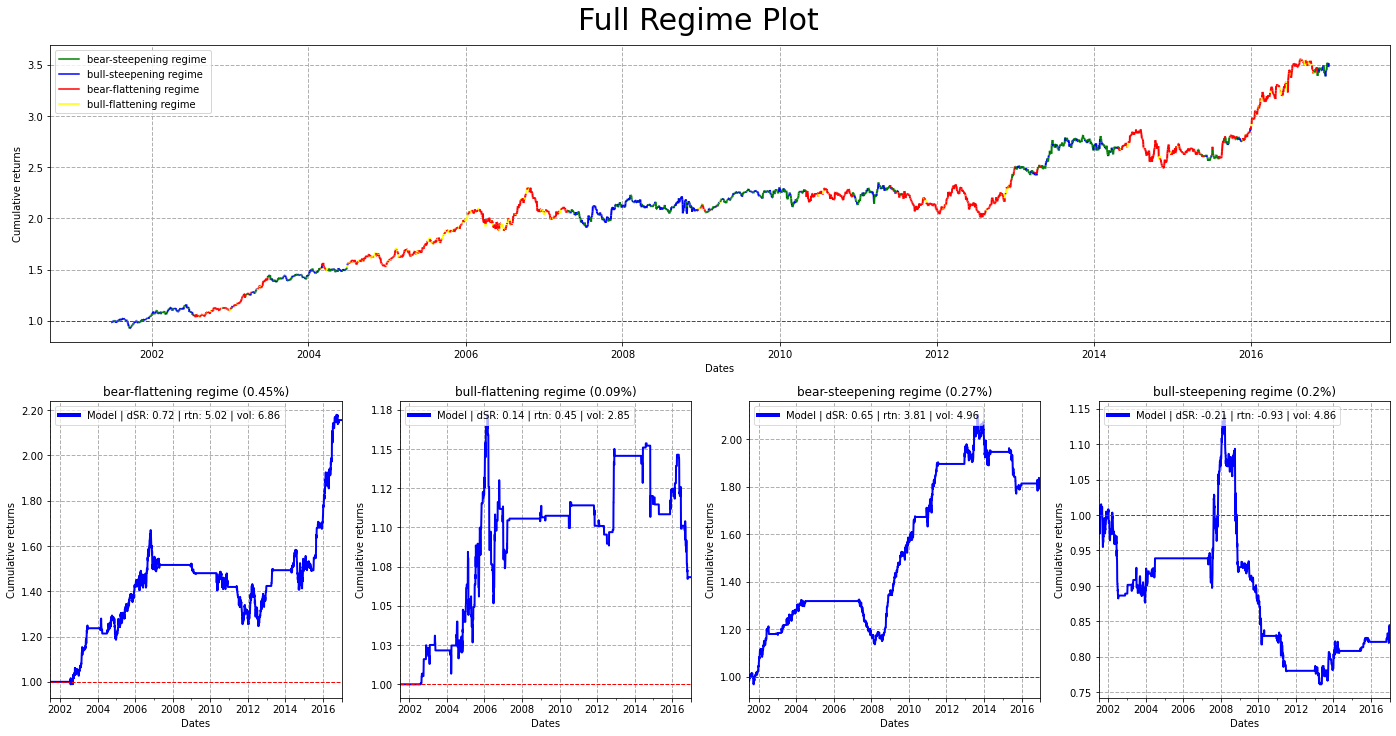

In [22]:
full_regime_plot(daily_bt, rates_regime)

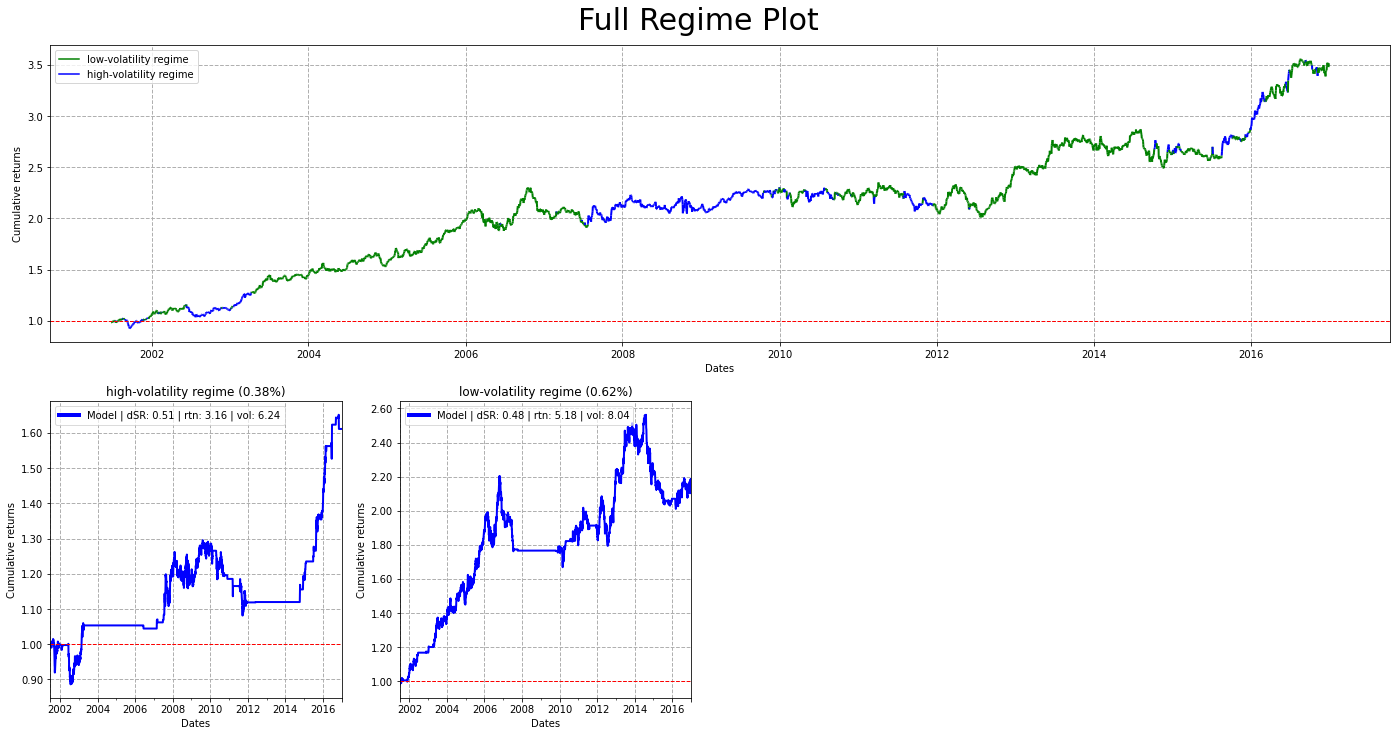

In [23]:
full_regime_plot(daily_bt, vol_regime)

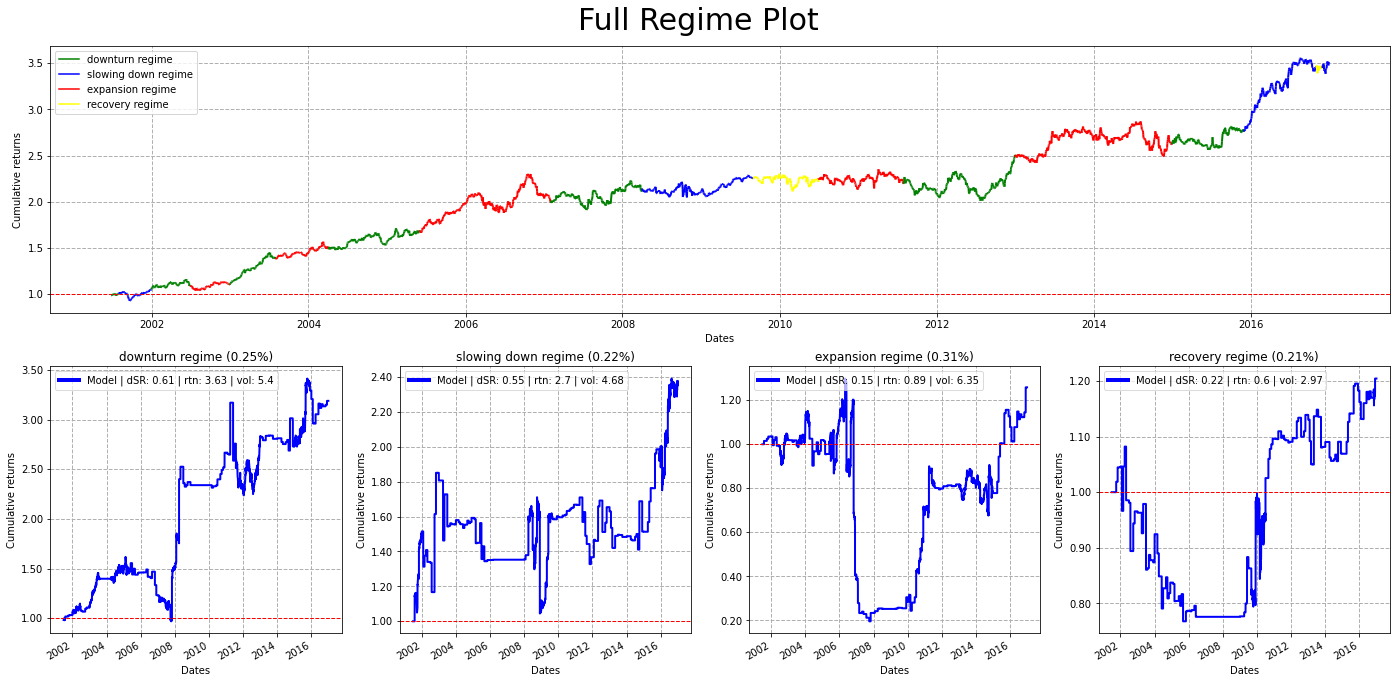

In [24]:
full_regime_plot(daily_bt, cycle_regime)

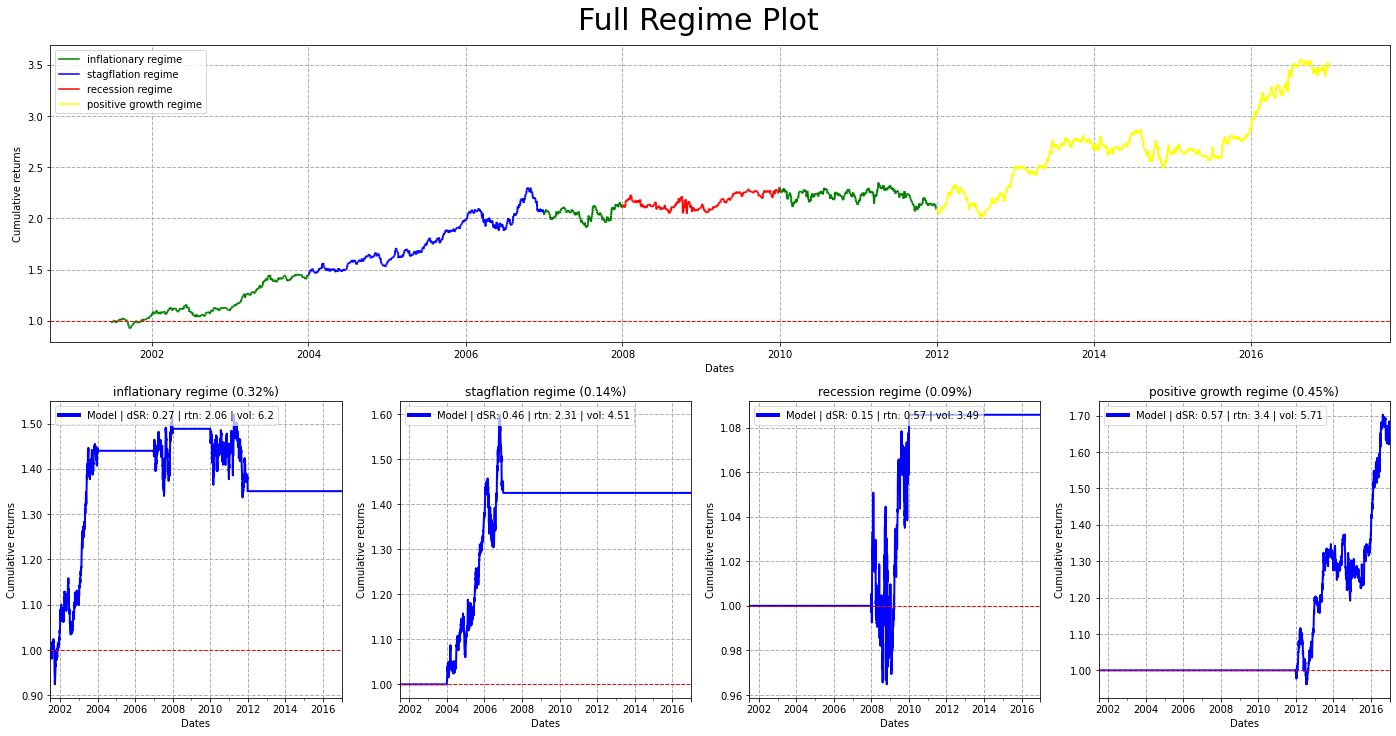

In [25]:
full_regime_plot(daily_bt, macro_regime)

# Sensitivity Analysis